<a href="https://colab.research.google.com/github/PraneelUJ/CS203_Lab_5/blob/main/task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
from transformers import AutoImageProcessor, ResNetConfig, ResNetForImageClassification
import torch
import os

In [48]:
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn as nn

## Model on original dataset

In [49]:
# Dataset paths
data_dir = "/content/drive/MyDrive/dataset"  # Update with your actual path

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 input
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard ResNet normalization
])

In [50]:
# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Manual dataset split
train_indices = list(range(0, 56 * 2))  # First 56 per class
test_indices = list(range(56 * 2, 70 * 2))  # Remaining 14 per class

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [51]:
# Map class indices for better clarity
class_names = dataset.classes
print("Classes:", class_names)

Classes: ['cats', 'dogs']


In [59]:
from transformers import ResNetConfig, ResNetForImageClassification

config = ResNetConfig.from_pretrained("microsoft/resnet-50")
config.num_labels = len(class_names)
model = ResNetForImageClassification(config)

In [60]:
# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [61]:
device

device(type='cuda')

In [62]:
# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs).logits  # .logits for transformers models
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_dataloader)}")

print("Training complete.")

Epoch 1/5, Loss: 1.4792621902057104
Epoch 2/5, Loss: 0.8117852551596505
Epoch 3/5, Loss: 0.6690282225608826
Epoch 4/5, Loss: 0.5961585811206273
Epoch 5/5, Loss: 0.6984169142586845
Training complete.


In [63]:
# Evaluate the model
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).logits
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

In [64]:
# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

Accuracy: 32.14%
Precision: 100.00%
Recall: 32.14%
F1 Score: 48.65%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


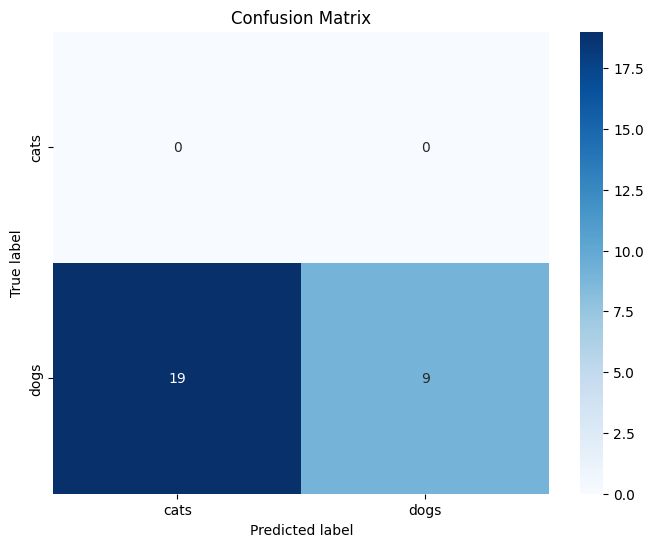

In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


## Model on augmented dataset

In [ ]:
# Dataset paths
data_dir = "/content/drive/MyDrive/dataset_augmented"

dataset_augmented = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader_augmented = DataLoader(dataset_augmented, batch_size=16, shuffle=True)

In [ ]:
config = ResNetConfig.from_pretrained("microsoft/resnet-50")
config.num_labels = len(class_names)  # Set number of output classes
model = ResNetForImageClassification(config)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in dataloader_augmented:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs).logits  # .logits for transformers models
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_dataloader)}")

print("Training complete.")

In [ ]:
# Evaluate the model
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).logits
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

In [ ]:
# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")